In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

def download_images():
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/test_images/'
    filenames = ['image1.jpg', 'image2.jpg']
    image_paths = []
    for filename in filenames:
        image_path = tf.keras.utils.get_file(fname=filename,
                                            origin=base_url + filename,
                                            untar=False)
        image_path = pathlib.Path(image_path)
        image_paths.append(str(image_path))
    return image_paths

IMAGE_PATHS = download_images()

1417216/1415684 [==============================] - 0s 0us/step


In [ ]:
IMAGE_PATHS

['/root/.keras/datasets/image1.jpg', '/root/.keras/datasets/image2.jpg']

In [ ]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

1426464768/1426460092 [==============================] - 8s 0us/step


In [ ]:
PATH_TO_MODEL_DIR

'/root/.keras/datasets/centernet_hg104_1024x1024_coco17_tpu-32'

In [ ]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

8192/5056 [================================================] - 0s 0us/step


In [ ]:
PATH_TO_LABELS

'/root/.keras/datasets/mscoco_label_map.pbtxt'

In [ ]:
cp /root/.keras/datasets/mscoco_label_map.pbtxt /content

In [ ]:
cd /content

/content


In [ ]:
!git clone https://github.com/tensorflow/models.git

In [ ]:
cd /content/models/research

/content/models/research


In [ ]:
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git

In [ ]:
cd cocoapi/PythonAPI

/content/models/research/cocoapi/PythonAPI


In [ ]:
!make

In [ ]:
cp -r pycocotools /content/models/research

In [ ]:
cd ../..

/content/models/research


In [ ]:
cp object_detection/packages/tf2/setup.py .

In [ ]:
!python -m pip install .

In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

# **Custom Model**

# **TFOD MODEL**

In [ ]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap('/content/mscoco_label_map.pbtxt',
                                                                    use_display_name=True)

Running inference for /content/test/image11.jpg... 

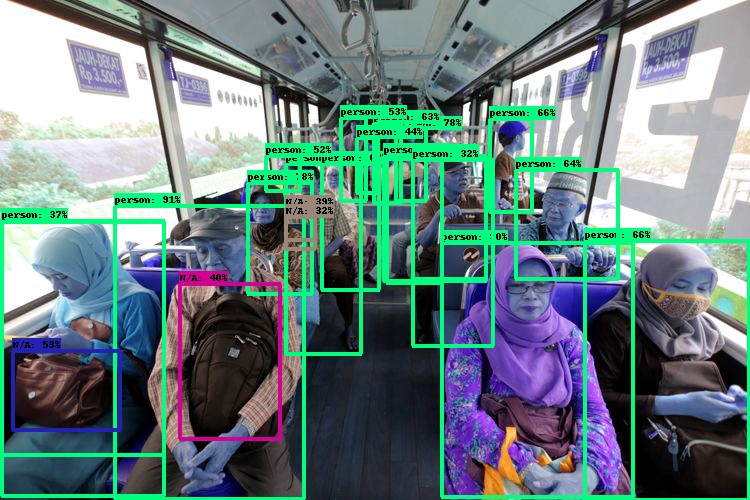

Done
19


<Response [200]>

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from google.colab.patches import cv2_imshow
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


#for image_path in IMAGE_PATHS:
for image_path in ['/content/test/image11.jpg']:
    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    #plt.imshow(image_np_with_detections)
    cv2_imshow(image_np_with_detections)
    print('Done')
#plt.show()

# sphinx_gallery_thumbnail_number = 2
total_person = 0
for x in range(100):
  if detections['detection_scores'][x] >= 0.30:
    if detections['detection_classes'][x] == 1:
      total_person += 1

print(total_person)
requests.post("http://34.134.73.165:3000/report", json={"busid": "bus1","people":str(total_person)})

In [ ]:
#print(detections['detection_boxes'])
#print(detections['detection_classes'])
#print(detections['detection_scores'])
#print(num_detections)
total_person = 0
for x in range(100):
  if detections['detection_scores'][x] >= 0.30:
    if detections['detection_classes'][x] == 1:
      total_person += 1

print(total_person)

4


In [ ]:
requests.post("http://34.134.73.165:3000/report", json={"busid": "bus1","people":str(total_person)})

In [ ]:
!curl --location --request POST '34.134.73.165:3000/report' --header 'Content-Type: application/json' --data-raw '{"busid": "bus1","people": 19}'

ok

In [ ]:
requests.post("http://34.134.73.165:3000/report", json={"busid": "bus1","people":str(total_person)})

<Response [200]>

In [ ]:
sampleDict = {
    "busid": "bus1",
    "people":str(total_person)
}

jsonData = json.dumps(sampleDict)


In [ ]:
import json

In [ ]:
"""
Object Detection (On Image) From TF2 Saved Model
=====================================
"""

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf
import cv2
import argparse
from google.colab.patches import cv2_imshow

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# PROVIDE PATH TO IMAGE DIRECTORY
IMAGE_PATHS = '/content/drive/MyDrive/Bangkit/Project/Tensorflow/test_images/image7.jpg'


# PROVIDE PATH TO MODEL DIRECTORY
PATH_TO_MODEL_DIR = '/content/drive/MyDrive/Bangkit/Project/Tensorflow/workspace/training_demo/exported-models/my_model/versi_1'

# PROVIDE PATH TO LABEL MAP
PATH_TO_LABELS = '/content/drive/MyDrive/Bangkit/Project/Tensorflow/workspace/training_demo/annotations/label_map.pbtxt'

# PROVIDE THE MINIMUM CONFIDENCE THRESHOLD
MIN_CONF_THRESH = float(0.60)

# LOAD THE MODEL

import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# LOAD SAVED MODEL AND BUILD DETECTION FUNCTION
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

# LOAD LABEL MAP DATA FOR PLOTTING

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    Args:
      path: the file path to the image
    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))




print('Running inference for {}... '.format(IMAGE_PATHS), end='')

image = cv2.imread(IMAGE_PATHS)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb, axis=0)

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# input_tensor = np.expand_dims(image_np, 0)
detections = detect_fn(input_tensor)

# All outputs are batches tensors.
# Convert to numpy arrays, and take index [0] to remove the batch dimension.
# We're only interested in the first num_detections.
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
               for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

image_with_detections = image.copy()

# SET MIN_SCORE_THRESH BASED ON YOU MINIMUM THRESHOLD FOR DETECTIONS
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=0.5,
      agnostic_mode=False)

print('Done')
# DISPLAYS OUTPUT IMAGE
cv2_imshow(image_with_detections)
# CLOSES WINDOW ONCE KEY IS PRESSED